In [1]:
import sys
print("python version: ", sys.version)

import pandas as pd
print("pandas version: ", pd.__version__)

import numpy as np
print('numpy version: ', np.__version__)

import scipy as sp
print('scipy version: ', sp.__version__)

import sklearn as skl
print('sklearn version: ', skl.__version__)

import matplotlib.pyplot as plt

import seaborn as sns

import keras as ks
print('keras version: ', ks.__version__)
print('keras backend: ', ks.backend.backend())

import tensorflow as tf
print('tensorflow version: ', tf.__version__)

import theano as th
print('theano version: ', th.__version__)

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras import backend as K
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, precision_recall_curve

import os
import random
from datetime import datetime

('python version: ', '2.7.15 | packaged by conda-forge | (default, Oct 12 2018, 14:10:51) \n[GCC 7.3.0]')
('pandas version: ', u'0.23.4')
('numpy version: ', '1.15.4')
('scipy version: ', '1.1.0')
('sklearn version: ', '0.19.2')


Using TensorFlow backend.


('keras version: ', '2.2.4')
('keras backend: ', u'tensorflow')
('tensorflow version: ', '1.10.0')
('theano version: ', '0.8.2')


In [303]:
def set_keras_backend(backend):
    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        reload(K)
        assert K.backend() == backend

set_keras_backend("theano")

Using Theano backend.


In [2]:
excel_file = r'../Geri-DL-data/data-dictionary.xlsx'
data = pd.DataFrame(pd.read_excel(excel_file,sheet_name='Measures'))
data_copy = data.copy()
print(data.shape)
# data.head()

(13422, 191)


In [3]:
def groupById(data, col='patient-id'):
    g = data.groupby(col)
    print 'Number of unique IDs: %d\n' % len(g)
    return g

data_not_ed = data[data['Entry-discharge-type']=='Not entry/discharge record']
print(data_not_ed.shape)
group_not_ed = groupById(data_not_ed)

group_size = group_not_ed.size()
data_lt_one = data_not_ed[ data_not_ed['patient-id'].isin(group_size[group_size > 1].index) ]
print(data_lt_one.shape)
groupById(data_lt_one)

data_no_fall = data_not_ed.loc[data['outcome-Mds-fall-since-prior-assessment']=='Yes']
groupById(data_no_fall)

(7584, 191)
Number of unique IDs: 3133

(5702, 191)
Number of unique IDs: 1251

Number of unique IDs: 709



In [4]:
missing_cnt = data_lt_one.isna().sum()
missing_data = pd.concat([missing_cnt, missing_cnt/data_lt_one.shape[0]], axis=1, keys=['count', 'percentage'])
# missing_data = missing_data.loc[missing_data['count']!=0].sort_values('percentage', ascending=False)
missing_zero = missing_data[missing_data['count'] == 0]
# print(missing_zero)

In [5]:
df = data_lt_one[missing_zero[missing_zero.index.str.contains('^(?!.*(-date|ws-|outcome-|Entry)).*$')].index.tolist()]
print(df.shape)
target = data_lt_one['outcome-Mds-fall-since-prior-assessment']
print(target.shape)

(5702, 39)
(5702,)


In [6]:
f_obj = df.dtypes[df.dtypes == 'object'].index
print(f_obj)

Index([u'cms-long-stay', u'mds-stay-trans-short-to-long', u'gender', u'race',
       u'facility', u'mds-antianxiety-medication',
       u'mds-antidepressant-medication', u'mds-antipsychotic-medication',
       u'mds-antibiotic-medication', u'mds-anticoagulant-medication',
       u'mds-diuretic-medication', u'mds-hypnotic-medication',
       u'mds-behavioral-symptoms', u'mds-behavioral-symptoms-to-others',
       u'mds-bims-summary-ranking', u'mds-dehydrated', u'mds-depression',
       u'mds-fever', u'mds-impaired-mobility', u'mds-impaired-transfer',
       u'mds-internal-bleeding', u'mds-pain-non-verbal', u'mds-malnutrition',
       u'mds-no-problem-conditions', u'mds-vomiting', u'PPS-assessment',
       u'Federal-assessment', u'mds-impaired-walk-in-room',
       u'mds-impaired-walk-in-corridor', u'mds-impaired-locomot-unit',
       u'mds-impaired-locomot-other'],
      dtype='object')


In [7]:
f_numeric = df.dtypes[df.dtypes != 'object'].index
print(f_numeric)

Index([u'patient-id', u'current-stay-days', u'cumulative-days-in-facility',
       u'age', u'cns-drug-exposure', u'psychotropic-exposure',
       u'pk-interaction', u'mds-adl-scale'],
      dtype='object')


In [8]:
f_not_bin = ['mds-bims-summary-ranking', 'PPS-assessment', 'Federal-assessment', 'gender', 'race', 'facility']
df = pd.get_dummies(df, columns=f_not_bin, prefix=f_not_bin)
df['mds-pain-non-verbal'] = df['mds-pain-non-verbal'].map({'None/Mild': 0, 'Moderate/Severe': 1})
f_obj = f_obj.drop(f_not_bin + ['mds-pain-non-verbal'])
for f in f_obj:
    df[f] = df[f].map({'No': 0, 'Yes': 1})
target = target.map({'None': 0, 'Yes': 1})
print(df.dtypes[df.dtypes == 'object'].index)

Index([], dtype='object')


boolean:
'cms-long-stay', 'mds-stay-trans-short-to-long', '*-medication'
'mds-pain-non-verbal'

not-boolean:
'mds-bims-summary-ranking', 'PPS-assessment', 'Federal-assessment', 

drop:
'Entry-discharge-type'

In [9]:
df['target'] = target

In [10]:
'''
 Generate input list for generator
 
 Returns:
    x: [Patient 1, Patient 2, ...]
       in Patient X: [Record 1, Record 2, ...]
       type of record is ndarray    
    y: [Patient 1, Patient 2, ...]
       Patient X is series of target (compatible with ndarray)
'''
def generate_nested_list(df):
    x, y = [], [] 
    index = df['patient-id'].unique()
    for idx in index:
        dff = df[df['patient-id']==idx]
        
        # Method 1, T-1 feature(redunant) & T-1 target & T feature as INPUT, 
#         cols, names = list(), list()
#         cols.append(dff.shift(1))
#         names += [('%s_1' % col_name) for col_name in dff.columns]
#         cols.append(dff.shift(0))
#         names += [('%s' % col_name) for col_name in dff.columns]
#         agg = pd.concat(cols, axis=1)
#         agg.columns = names
#         agg.dropna(inplace=True)
#         y.append(agg['target'])
#         agg.drop('target', axis=1, inplace=True)
#         x.append([xx for xx in agg.values])

        # Method 2, T feature as INPUT, lack T-1 actual value
#         y.append(dff['target'])
#         dff.drop('target', axis=1, inplace=True)
#         x.append([value for value in dff.values])

        # Method 3, T-1 target & T feature as INPUT
        dff['target_1'] = dff['target'].shift(1)
        dff = dff[1:]
        y.append(dff['target'])
        dff = dff.drop(['patient-id', 'target'], axis=1)
        x.append([record for record in dff.values])
    return x, y

In [11]:
%%time
xmat, ymat = generate_nested_list(df)

CPU times: user 1min 25s, sys: 24 ms, total: 1min 25s
Wall time: 1min 25s


In [12]:
print(len(xmat))
print(len(xmat[0]))
print(xmat[0][0].shape[0])
print(len(ymat))
print(ymat[0].shape[0])

1251
1
58
1251
1


In [13]:
def check_dim(x, y):
    result = [ (len(x[i]) == y[i].shape[0]) for i in range(len(y)) ]
    if(False not in result):
        print('All dimensions match.')
        return True;
    else:
        print('Some dimensions do not match.')
        return result;

In [14]:
def train_test_split(xmat, ymat, radio, seed):
    random.seed(seed)
    n_total = sum(y.shape[0] for y in ymat)
    print('total number of samples: %d' % n_total)
    X_train, X_test, Y_train, Y_test = ([], ) * 4
    idx = random.sample(range(len(ymat)), len(ymat))
    n_train = 0
    for i, val in enumerate(idx):
        n_train += len(ymat[val])
        if(n_train >= n_total * radio):
            X_train, Y_train = [xmat[j] for j in idx[:i]], [ymat[j] for j in idx[:i]]
            X_test, Y_test = [xmat[j] for j in idx[i:]], [ymat[j] for j in idx[i:]]
            print('total number of samples in training set: %d' % n_train)
            break
    return X_train, X_test, Y_train, Y_test

In [15]:
def train_test_split_by_patient(xmat, ymat, radio, seed):
    random.seed(seed)
    idx = random.sample(range(len(ymat)), len(ymat))
    i = int(len(ymat) * radio)
    X_train, Y_train = [xmat[j] for j in idx[:i]], [ymat[j] for j in idx[:i]]
    X_test, Y_test = [xmat[j] for j in idx[i:]], [ymat[j] for j in idx[i:]]
    return X_train, X_test, Y_train, Y_test

In [16]:
def nested_list_to_df(layer1, col_names):
    li = [layer3 for layer2 in layer1 for layer3 in layer2]
    return pd.DataFrame(np.row_stack(li), columns=col_names)

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(xmat, ymat, 0.7, 1)

total number of samples: 4451
total number of samples in training set: 3117


In [274]:
X_train, X_test, Y_train, Y_test = train_test_split_by_patient(xmat, ymat, 0.7, 1)

In [18]:
print(len(X_train))
print(len(X_train[0]))
print(X_train[0][0].shape[0])
print(len(Y_train))
print(Y_train[0].shape[0])

904
1
58
904
1


In [19]:
check_dim(X_train, Y_train)

All dimensions match.


True

In [20]:
col_names = df.columns.tolist()[1:-1]
col_names.append('target_1')
# print(col_names)

In [278]:
nested_list_to_df(X_train, col_names).shape

(3031, 58)

In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(pd.DataFrame(np.concatenate(X_train)))
X_train_transformed = list()
for X in X_train:
    X_train_transformed.append(scaler.transform(X))
scaler.fit(pd.DataFrame(np.concatenate(X_test)))
X_test_transformed = list()
for X in X_test:
    X_test_transformed.append(scaler.transform(X))

In [22]:
def mygenerator(obj):
    if(isinstance(obj, tuple)):
        xmat, ymat = obj
        while True:
            for x, y in zip(xmat, ymat):
                yield (np.array(x).reshape((len(x), 1, x[0].shape[0])), y)
    else:
        xmat = obj
        while True:
            for x in xmat:
                yield (np.array(x).reshape((len(x), 1, x[0].shape[0])))

In [23]:
model = Sequential()
n_timesteps = 1
n_dimensions = xmat[0][0].shape[0]
model.add(LSTM(20, input_shape=(n_timesteps, n_dimensions)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['binary_accuracy'])

Epoch 1/100
904/904 [==============================] - 2s 3ms/step - loss: 0.4791 - binary_accuracy: 0.8186 - val_loss: 0.5137 - val_binary_accuracy: 0.7867
Epoch 2/100
904/904 [==============================] - 2s 2ms/step - loss: 0.4612 - binary_accuracy: 0.8203 - val_loss: 0.5052 - val_binary_accuracy: 0.7867
Epoch 3/100
904/904 [==============================] - 2s 2ms/step - loss: 0.4519 - binary_accuracy: 0.8203 - val_loss: 0.5000 - val_binary_accuracy: 0.7867
Epoch 4/100
904/904 [==============================] - 2s 2ms/step - loss: 0.4485 - binary_accuracy: 0.8201 - val_loss: 0.4957 - val_binary_accuracy: 0.7882
Epoch 5/100
904/904 [==============================] - 2s 2ms/step - loss: 0.4426 - binary_accuracy: 0.8213 - val_loss: 0.4921 - val_binary_accuracy: 0.7874
Epoch 6/100
904/904 [==============================] - 2s 2ms/step - loss: 0.4411 - binary_accuracy: 0.8225 - val_loss: 0.4894 - val_binary_accuracy: 0.7874
Epoch 7/100
904/904 [==============================] - 2s 

Epoch 53/100
904/904 [==============================] - 2s 2ms/step - loss: 0.4136 - binary_accuracy: 0.8294 - val_loss: 0.4689 - val_binary_accuracy: 0.7904
Epoch 54/100
904/904 [==============================] - 2s 2ms/step - loss: 0.4170 - binary_accuracy: 0.8286 - val_loss: 0.4689 - val_binary_accuracy: 0.7904
Epoch 55/100
904/904 [==============================] - 2s 2ms/step - loss: 0.4242 - binary_accuracy: 0.8303 - val_loss: 0.4687 - val_binary_accuracy: 0.7904
Epoch 56/100
904/904 [==============================] - 2s 2ms/step - loss: 0.4143 - binary_accuracy: 0.8279 - val_loss: 0.4687 - val_binary_accuracy: 0.7904
Epoch 57/100
904/904 [==============================] - 2s 2ms/step - loss: 0.4134 - binary_accuracy: 0.8326 - val_loss: 0.4687 - val_binary_accuracy: 0.7912
Epoch 58/100
904/904 [==============================] - 2s 2ms/step - loss: 0.4124 - binary_accuracy: 0.8322 - val_loss: 0.4686 - val_binary_accuracy: 0.7904
Epoch 59/100
904/904 [==============================

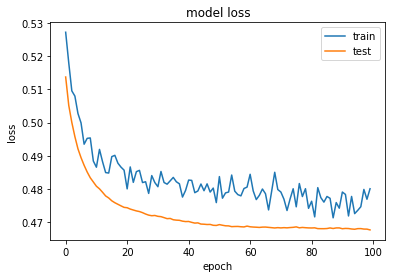

CPU times: user 7min 40s, sys: 1min 30s, total: 9min 10s
Wall time: 3min 1s


In [24]:
%%time
history = model.fit_generator(mygenerator((X_train_transformed, Y_train)), steps_per_epoch=len(X_train_transformed), \
                              epochs=100, validation_data=mygenerator((X_test_transformed, Y_test)), \
                              validation_steps=len(X_test_transformed))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Confusion Matrix:
[[1014   37]
 [ 240   45]]
('Precision score: ', 0.5487804878048781)
('Recall score: ', 0.15789473684210525)
('Accuracy: ', 0.7926646706586826)
('F1 score: ', 0.24523160762942775)


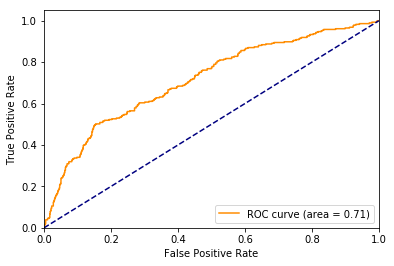

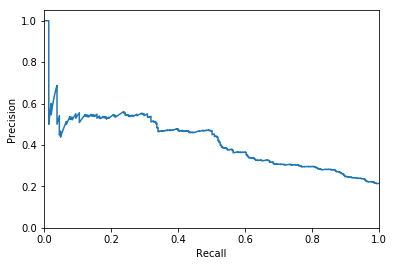

In [25]:
Y_predicted = model.predict_generator(mygenerator(X_test_transformed), steps=len(X_test_transformed))
Y_predicted_c = np.concatenate(Y_predicted)
Y_test_c = np.concatenate(Y_test)
Y_pred_0_5 = (Y_predicted_c > 0.5)
print('Confusion Matrix:')
print(confusion_matrix(Y_test_c, Y_pred_0_5))
print('Precision score: ', precision_score(Y_test_c, Y_pred_0_5))
print('Recall score: ', recall_score(Y_test_c, Y_pred_0_5))
fpr, tpr, thresholds = roc_curve(Y_test_c, Y_predicted_c, pos_label=1)
print('Accuracy: ', accuracy_score(Y_test_c, Y_pred_0_5))
print('F1 score: ', f1_score(Y_test_c, Y_pred_0_5))

def plot_roc_curve(fpr, tpr, saveplt=False, comment=''):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    if(saveplt):
        plt.savefig('./results/' + datetime.now().strftime('%Y%m%d_%H%M%S') + '_ROC'+ comment)
    plt.show()
    
def plot_precision_recall_curve(Y_test, Y_predicted, saveplt=False, comment=''):
    plt.figure()
    precision, recall, _ = precision_recall_curve(Y_test, Y_predicted)
    plt.plot(recall, precision)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    if(saveplt):
        plt.savefig('./results/' + datetime.now().strftime('%Y%m%d_%H%M%S') + '_Precision_Recall' + comment)
    plt.show()
        
plot_roc_curve(fpr, tpr)
plot_precision_recall_curve(Y_test_c, Y_predicted_c)
# plot_roc_curve(fpr, tpr, True, '_m3_r1_lstm20_e100_by_patient')
# plot_precision_recall_curve(Y_test_c, Y_predicted_c, True, '_m3_r1_lstm20_e100_by_patient')